Learn iterator for thermal problems using MFEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time

from utils import plot
from feanet.singlegrid import SingleGrid
from feanet.multigrid import MultiGrid
from data.dataset import MechanicalDataSet

Create plots for convergence test

In [2]:
N = [2**1+1, 2**2+1, 2**3+1, 2**4+1, 2**5+1, 2**6+1, 2**7+1, 2**8+1, 2**9+1]
q_v11 = [0.11111110105447959, 0.20320289267157887, 0.22705374241213908, 0.23623111562228755, 
         0.2521629576411248, 0.25900978515692, 0.26230444531364716, 0.26295500430251095, 0.26316125814795244]
q_jac = [0.33333329777930615, 0.7357023129437866, 0.9258110664371474, 0.9809080721911905, 0.9809080721911905, 
         0.9987957479351752, 0.9996457255615815, 0.9996247757202597, 0.9996247757202597]

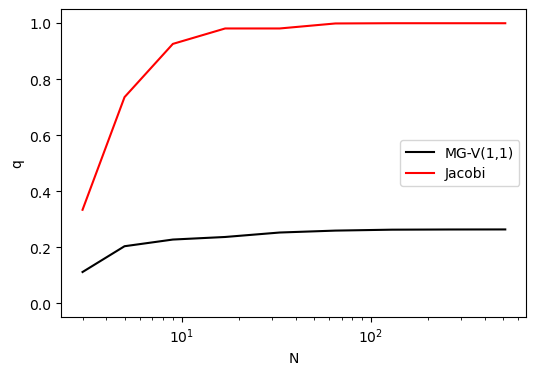

In [3]:
plt.figure(figsize=(6, 4))
plt.plot(N, q_v11, label='MG-V(1,1)', c='k')
plt.plot(N, q_jac, label='Jacobi', c='r')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('N')
plt.ylabel('q')
plt.legend(loc='center right')
plt.ylim([-0.05, 1.05])
plt.savefig('results/q_compare.png', dpi=500, bbox_inches='tight')

In [4]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
n_elem = 2**5 # element size on the edge
nb_layers = 3
bs = 5

train = True # True or False
model_name = 'thermal_33x33_smoother'
model_dir = 'model/learn_iterator/thermal'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [6]:
training_set = MechanicalDataSet('data/data_thermal/thermal_plate_train_33x33.h5', device)
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
elem_mask_train, node_mask_train, dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, neumann_conn_train, material_train, f_train, u_train = next(iter(train_dataloader))

test_set = MechanicalDataSet('data/data_thermal/thermal_plate_test_33x33.h5', device)
test_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
elem_mask_test, node_mask_test, dirich_idx_test, dirich_value_test, neumann_idx_test, neumann_value_test, neumann_conn_test, material_test, f_test, u_test = next(iter(test_dataloader))

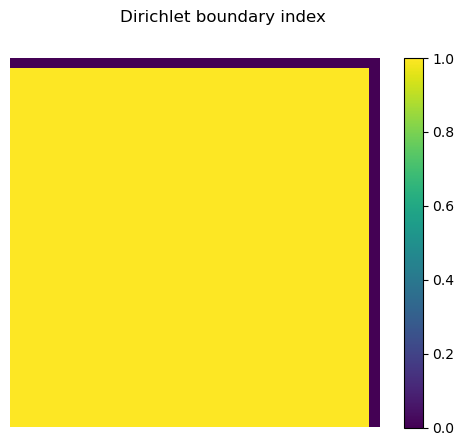

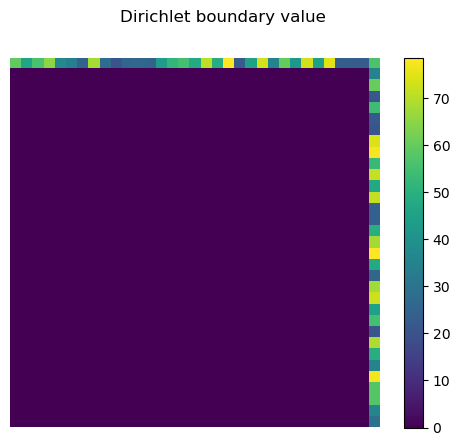

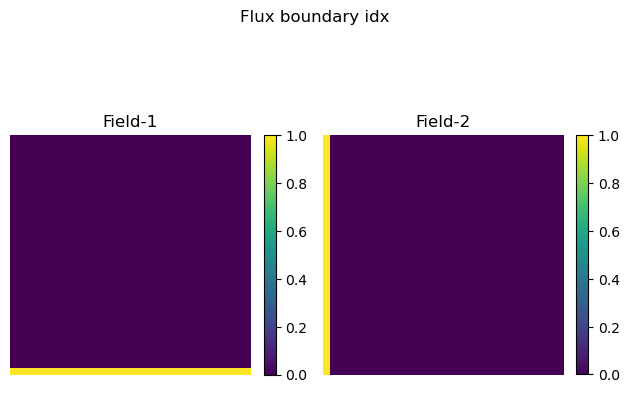

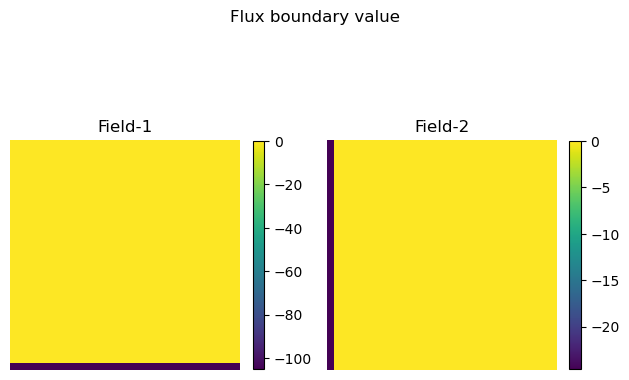

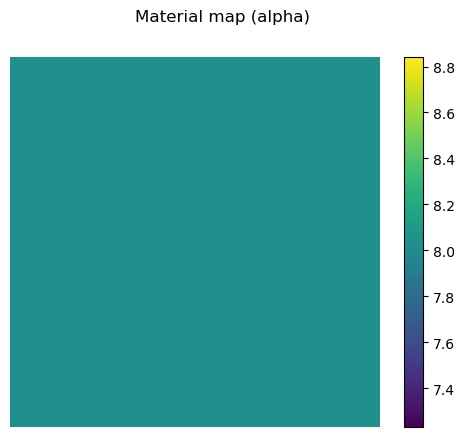

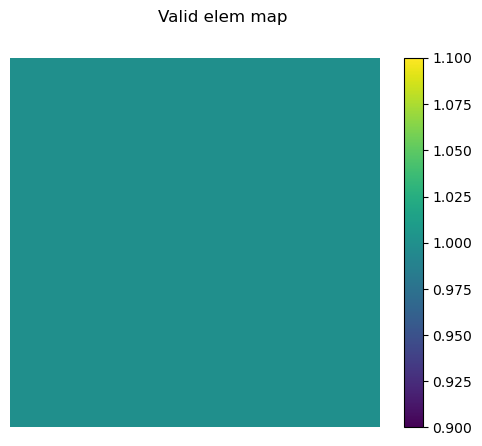

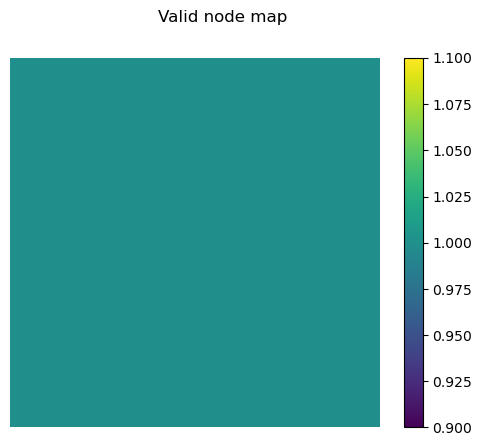

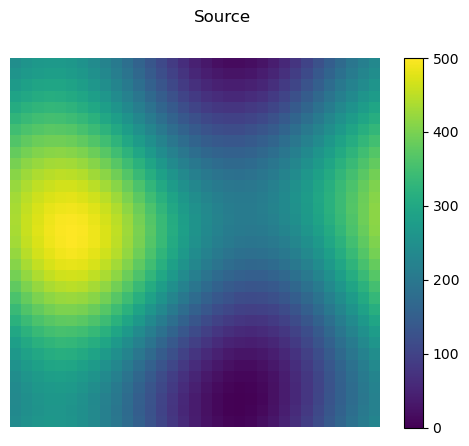

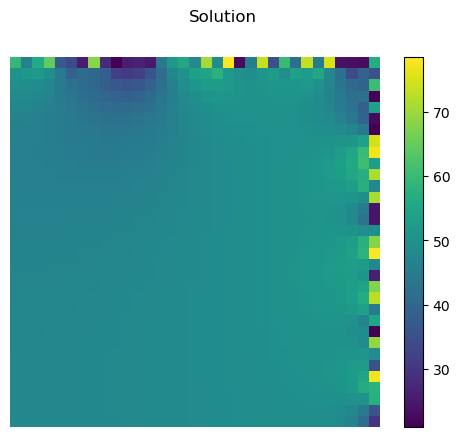

In [7]:
k = 0 # the index of test data to be shown
plot.plot_thermalfield(dirich_idx_test[k], ftitle='Dirichlet boundary index')
plot.plot_thermalfield(dirich_value_test[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(neumann_idx_test[k], ftitle='Flux boundary idx')
plot.plot_elasticfield(neumann_value_test[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_test[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(elem_mask_test[k], ftitle='Valid elem map')
plot.plot_thermalfield(node_mask_test[k], ftitle='Valid node map')
plot.plot_thermalfield(f_test[k], ftitle='Source')
plot.plot_thermalfield(u_test[k], ftitle='Solution')

Create a set of solution data for testing purpose

In [8]:
solution_test, rhs_test, d_test, d_idx_test, t_idx_test, t_test, t_conn_test, m_test, emsk_test, nmsk_test = (torch.unsqueeze(u_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_conn_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(elem_mask_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(node_mask_test[k], 0).to(device_predict))

In [9]:
hsize = 2e-3 # m
ku, kf = 1, 1
grid = SingleGrid(hsize, n_elem=n_elem, mode='thermal', dev=device_predict)

0 3085.599809824039
1 1713.8759161742278
2 1237.6730885138697
3 987.237822137283
4 830.126979921307
5 721.2914950072555
6 640.9248519898408
7 578.863142552668
8 529.3181376039925
9 488.73619239599014
10 454.8078601625534
11 425.9637887822799
12 401.09845450684173
13 379.4095808672488
14 360.3002127384362
15 343.3165706067386
16 328.1072624746361
17 314.39573183310836
18 301.96117682173787
19 290.62504445537417
20 280.2412846665748
21 270.68919528346527
22 261.8680871173945
23 253.69324993085473
24 246.09286281240466
25 239.0055999841219
26 232.37875541329262
27 226.16675912419817
28 220.3299925375894
29 214.83383444727244
30 209.64788659326072
31 204.74534033947148
32 200.10245514277108
33 195.69812628529047
34 191.51352440728917
35 187.53179319452323
36 183.73779447507567
37 180.11789220383145
38 176.65976852989152
39 173.35226647823956
40 170.18525482377723
41 167.14951156149908
42 164.23662303193575
43 161.43889628431074
44 158.74928268014338
45 156.16131107941854
46 153.66902922693

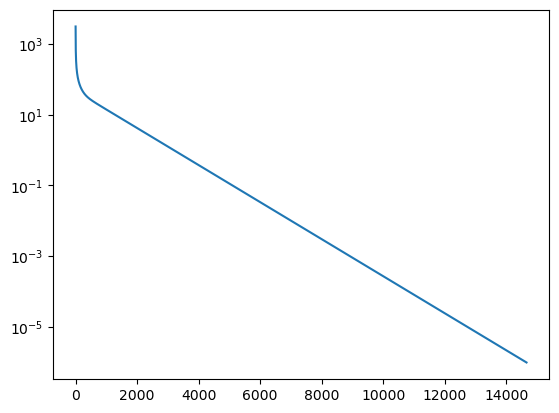

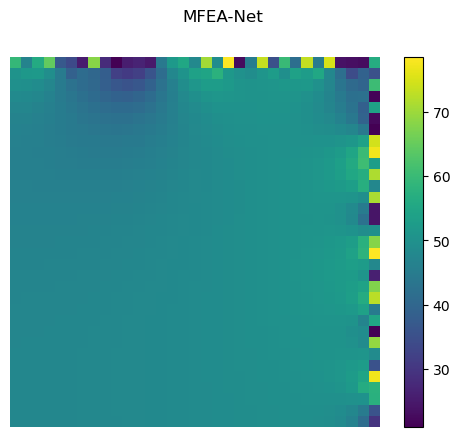

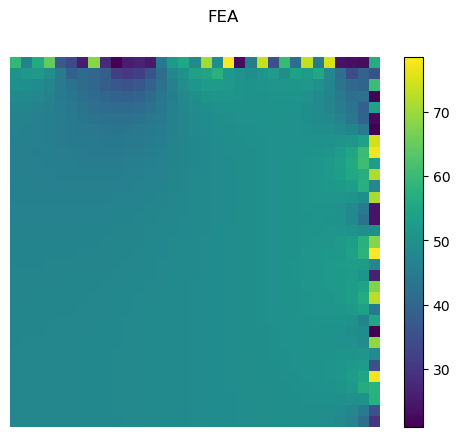

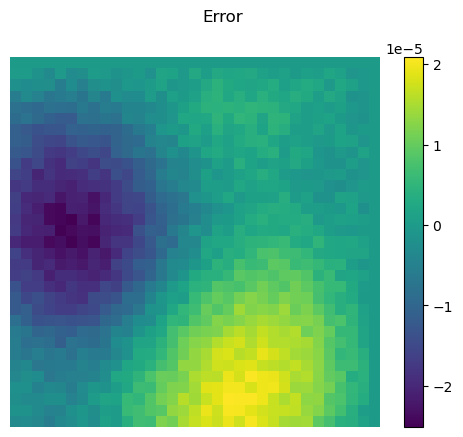

In [10]:
EPS = 1e-6
n_jac = 0
jacu_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
jacu_test = grid.jac.reset_boundary(jacu_test, d_test, d_idx_test)
residual = grid.net(None, None, hsize, jacu_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
res = torch.norm(residual).item() 
res_arr = [res]

if(True):
    print(n_jac, res)
    while (abs(res) > EPS):
        jacu_test = grid.jac.jacobi_convolution(jacu_test, m_test, nmsk_test, d_test, d_idx_test, None, None, hsize, rhs_test, t_test, t_conn_test)
        residual = grid.net(None, None, hsize, jacu_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item() 
        res_arr.append(res)
        n_jac += 1
        print(n_jac, res)

    print("Solution converges after", n_jac, "Jacobi iterations ")
    plt.plot(res_arr)
    plt.yscale('log')
    plt.show()

    plot.plot_thermalfield(jacu_test[0], "MFEA-Net")
    plot.plot_thermalfield(solution_test[0], "FEA")
    plot.plot_thermalfield(jacu_test[0]-solution_test[0], 'Error')

In [11]:
class PsiNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(PsiNet, self).__init__()

        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        # self.attention_map = nn.Sequential(
        #     nn.Conv2d(self.km, 1, kernel_size=2, padding=1),
        #     nn.Conv2d(1, 1, kernel_size=5, padding=2),
        #     nn.Conv2d(1, self.ku, kernel_size=1, padding=0),
        #     nn.Unfold(kernel_size=3, padding=1),
        #     nn.Tanh()
        #     )

        self.smoother = nn.ModuleList([nn.Conv2d(self.ku, self.ku, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, m, x, dirich_idx):
        '''
        m: material field
        x: error between Jacobi solution and initial guess '''
        
        # bs0, ku0, h0, w0 = x.size()
        # new_x = F.unfold(x, kernel_size = 3, padding = 1).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        # attention = self.attention_map(m).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        # attention_x = new_x * attention # shape (bs, ku, 9, h, w)
        # attention_x = attention_x.sum(dim=2) # shape (bs, ku, h, w)
        return reduce(lambda acc, el: el(acc) * dirich_idx, self.smoother, x) # shape (bs, ku, h, w)

In [12]:
class PsiIterator(nn.Module):
    def __init__(self, 
                 dev,
                 size=2, 
                 psi_net=None,
                 grid=None,
                 n=2**5,
                 nb_layers=3,
                 batch_size=1,
                 max_epochs=1000,
                 mode='thermal',
                 model_dir=model_dir):
        super(PsiIterator, self).__init__()
        self.size = size
        self.device = dev
        self.n = n
        self.h = size/n
        self.mode = mode
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss()
        
        if(grid is None):
            self.grid = SingleGrid(size, n, mode=mode, dev=self.device)
        else:
            self.grid = grid

        if(psi_net is None):
            self.psi_net = PsiNet(nb_layers=nb_layers, mode=self.mode).to(self.device).double()
        else:
            self.psi_net = psi_net.to(self.device).double()

        self.optimizer = torch.optim.Adadelta(self.psi_net.parameters())
        self.model_dir=model_dir

    def PsiRelax(self, v, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, num_sweeps_down=1):
        '''
        Perform a fixed number of Psi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
            u = jac_it + self.psi_net(m, jac_it-u, d_idx) 
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x).double().to(self.device)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = data
        
            #print(u_train.shape)
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            uu = self.RandomSampling(f_train)
            u_out = self.PsiRelax(uu, material_train, dirich_value_train, dirich_idx_train, None, None, self.h, f_train, traction_value_train, traction_idx_train, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        loss_train[0] = avg_loss
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.psi_net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train

In [13]:
max_epochs = 1000
my_iterator = PsiIterator(device, batch_size=bs, mode='thermal', nb_layers=nb_layers, max_epochs=max_epochs)

loss_train = torch.zeros((max_epochs, 1))
if(train):
    loss_train = my_iterator.Train(training_set)

    plt.plot(loss_train)
    plt.ylabel('loss')
    plt.yscale('log')
    plt.xlabel('epoch')
    print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

    # save the list
    torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


ValueError: too many values to unpack (expected 7)

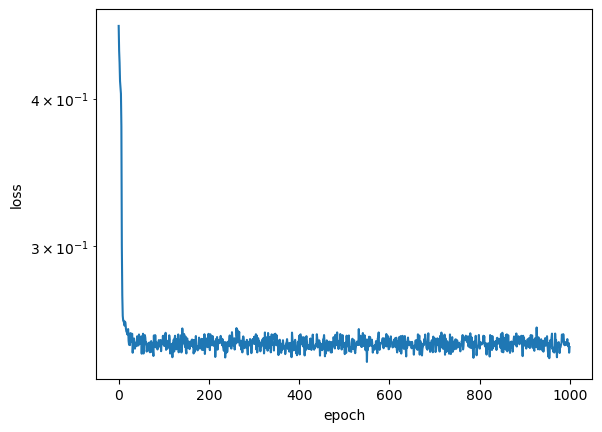

In [ ]:
# import the learned model and loss train
my_net = PsiNet(nb_layers=nb_layers, mode='thermal').to(device_predict)
my_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = PsiIterator(device_predict, nb_layers=nb_layers, psi_net=my_net, grid=grid, batch_size=1)

my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

In [ ]:
list(my_net.parameters())

[Parameter containing:
 tensor([[[[-0.1801, -0.0423, -0.0980],
           [-0.3856, -0.8469, -0.0458],
           [-0.1872, -0.0558, -0.1042]]]], device='cuda:0', dtype=torch.float64,
        requires_grad=True),
 Parameter containing:
 tensor([[[[-0.1603, -0.1868, -0.2941],
           [-0.1543,  0.1418, -0.7964],
           [-0.1590, -0.1859, -0.2896]]]], device='cuda:0', dtype=torch.float64,
        requires_grad=True),
 Parameter containing:
 tensor([[[[0.1687, 0.3316, 0.1615],
           [0.6435, 0.1527, 0.0752],
           [0.1650, 0.3294, 0.1628]]]], device='cuda:0', dtype=torch.float64,
        requires_grad=True)]

0 7.650158500205452
1 1.448844535980355
2 0.7424381506031571
3 0.5756762692668275
4 0.4886039297817334
5 0.4303970974819113
6 0.38707841238977203
7 0.35279824454025605
8 0.32456337668368046
9 0.30063702773859796
10 0.2799232940780364
11 0.261689799224603
12 0.24542619699314897
13 0.230764950506686
14 0.2174339385239173
15 0.2052267349824869
16 0.1939833126984271
17 0.18357716906610955
18 0.17390653722227334
19 0.1648882613519246
20 0.15645344488173188
21 0.1485442997422346
22 0.1411118231628674
23 0.13411405427109077
24 0.1275147439128778
25 0.12128232413075737
26 0.115389098760473
27 0.10981059998822462
28 0.1045250714896071
29 0.09951304954964219
30 0.09475702102665877
31 0.09024114227015106
32 0.08595100685411987
33 0.08187345271677116
34 0.07799640131895816
35 0.07430872295713761
36 0.07080012353339504
37 0.06746104899180416
38 0.06428260434403142
39 0.06125648477471191
40 0.05837491677261101
41 0.05563060760159695
42 0.053016701724436746
43 0.05052674303635313
44 0.048154641964915

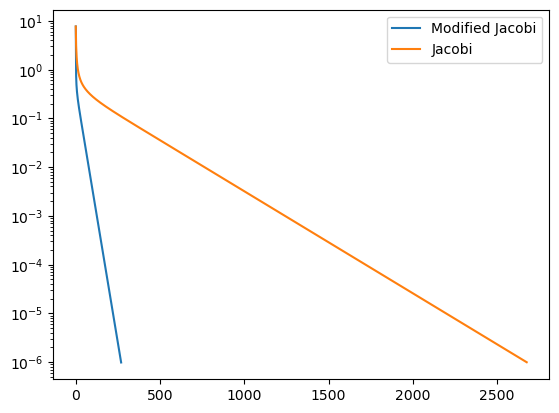

In [ ]:
EPS = 1e-6
with torch.no_grad():
    n_new = 0
    u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
    u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
    residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
    res_arr_new = [res]
    print(n_new, res)
    while (abs(res) > EPS):
        u_test = new_iterator.PsiRelax(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_new.append(res)
        n_new += 1
        print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
# test multigrid performance

class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, chs):
        super(RestrictionNet, self).__init__()
        self.chs = chs
        self.net = nn.Conv2d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restriction
        self.edge_net = nn.Conv1d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restrict the edge boundaries
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            self.edge_net.state_dict()['weight'][i][0] = torch.asarray([1., 2., 1.]) / 2.0
    
    def forward(self, x):
        internal = self.net(x[:, :, 1:-1, 1:-1].clone())
        x_C = F.pad(internal,(1,1,1,1),"constant",0) # coarse grid field
        x_C[:, :,  0, 1:-1] = self.edge_net(x[:, :, 0, 1:-1].clone())
        x_C[:, :, -1, 1:-1] = self.edge_net(x[:, :, -1, 1:-1].clone())
        x_C[:, :, 1:-1,  0] = self.edge_net(x[:, :, 1:-1, 0].clone())
        x_C[:, :, 1:-1, -1] = self.edge_net(x[:, :, 1:-1, -1].clone())
        x_C[:,:,0,0] = x[:,:,0,0]
        x_C[:,:,0,-1] = x[:,:,0,-1]
        x_C[:,:,-1,0] = x[:,:,-1,0]
        x_C[:,:,-1,-1] = x[:,:,-1,-1]
        return x_C


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, chs):
        super(ProlongationNet, self).__init__()
        self.chs = chs
        self.net = nn.ConvTranspose2d(in_channels=chs,out_channels=chs, kernel_size=3, stride=2, padding=1, bias=False, groups=chs) # interpolation
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            
    def forward(self, x): 
        return self.net(x)

In [ ]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, pacnet, device, nb_layers, mode='thermal', iterator = 'jac'):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.device = device
        self.size = 2.
        self.nb_layers = nb_layers
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.pacnet = pacnet
        self.iterator = iterator
        
        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2

        self.iterators = self.IteratorDict() # dictionary of iterators

        # Inter-grid communication network models
        self.conv = RestrictionNet(self.kf).double().to(device)
        self.deconv = ProlongationNet(self.ku).double().to(device)
        
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)

        self.mse_loss = nn.MSELoss()
    
    def IteratorDict(self):
        iterators = {}
        for i in range(self.L):
            prob_size = int(self.n/(2.**i))
            iterators[i] = PsiIterator(self.device, size=self.size, psi_net=self.pacnet, n=prob_size, nb_layers=self.nb_layers, mode=self.mode)
        return iterators
            
    def ProblemDictArray(self, u0, f, t, t_idx, d, d_idx, m):
        '''
        Array of dictionary that stores the problem hierarchy
        There are two approaches that can be used to create grid hierarchy:
        1) mat = F.conv2d(mat.reshape((1,1,n,n)), torch.ones((1,1,1,1)), stride=2)
        2) mat = F.max_pool2d(mat.reshape((1,1,n,n)), kernel_size=2, stride=2)
        '''
        kernel_u = torch.ones((self.ku,1,1,1)).double().to(self.device)
        kernel_f = torch.ones((self.kf,1,1,1)).double().to(self.device)
        prob = {}
        prob['h'] = self.size/self.n
        prob['u0'] = self.iterators[0].grid.jac.reset_boundary(u0, d, d_idx)
        prob['f'], prob['t'], prob['t_idx'] = f.clone(), t.clone(), t_idx.clone()
        prob['d'], prob['d_idx'], prob['m'] = d.clone(), d_idx.clone(), m.clone()
        self.p_arr = [prob]
        for i in range(self.L-1):
            prob = {}
            prob['h'] = self.size/self.n*(2.**(i+1))
            prob['u0'] = F.conv2d(self.p_arr[i]['u0'], kernel_u, stride=2, groups=self.ku)
            prob['f'] = F.conv2d(self.p_arr[i]['f'], kernel_f, stride=2, groups=self.kf)
            prob['t'] = F.conv2d(self.p_arr[i]['t'], kernel_f, stride=2, groups=self.kf)
            prob['t_idx'] = F.conv2d(self.p_arr[i]['t_idx'], kernel_f, stride=2, groups=self.kf)
            prob['d'] = 0.*F.conv2d(self.p_arr[i]['d'], kernel_u, stride=2, groups=self.ku) # Dirichlet boundary is homogeneous at coarse grids
            prob['d_idx'] = F.conv2d(self.p_arr[i]['d_idx'], kernel_u, stride=2, groups=self.ku)
            prob['m'] = F.max_pool2d(self.p_arr[i]['m'], kernel_size=2, stride=2)
            self.p_arr.append(prob)

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        '''
        rFC = self.conv(rF.clone())
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def forward(self, k):
        U = self.p_arr[0]['u0'].clone()
        for i in range(k-1):
            U = self.Step(U).detach()
        self.last_v = U.clone()
        return self.Step(U)

    def Relax(self, iter, u, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, n_iter=1):
        if(self.iterator == 'jac'):
            return iter.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
        else:
            return iter.PsiRelax(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx, n_iter)

    def Step(self, v):
        '''Input v is the initial solution on the finest grid'''
        n_relax = 1 # number of relaxations        
        self.iterators[0].grid.v = self.Relax(self.iterators[0], v, self.p_arr[0]['m'], 
                                              self.p_arr[0]['d'], self.p_arr[0]['d_idx'],
                                              None, None,
                                              self.p_arr[0]['h'], self.p_arr[0]['f'], 
                                              self.p_arr[0]['t'], self.p_arr[0]['t_idx'], 
                                              n_relax)
        self.iterators[0].grid.f = self.iterators[0].grid.net.term_F

        for j in range(0, self.L-1):
            # calculate fine grid residual
            rF = self.iterators[j].grid.net(u=self.iterators[j].grid.v, material_input=self.p_arr[j]['m'],
                                            term_F=self.iterators[j].grid.f)
            self.iterators[j+1].grid.f = self.Restrict(rF)
            self.iterators[j+1].grid.v = torch.zeros_like(self.iterators[j+1].grid.f) 
            self.iterators[j+1].grid.v = self.Relax(self.iterators[j+1], self.iterators[j+1].grid.v, 
                                              self.p_arr[j+1]['m'], 
                                              self.p_arr[j+1]['d'], self.p_arr[j+1]['d_idx'],
                                              term_F=self.iterators[j+1].grid.f, 
                                              n_iter=n_relax)

        self.iterators[self.L-1].grid.v = self.Relax(self.iterators[self.L-1], self.iterators[self.L-1].grid.v, 
                                              self.p_arr[self.L-1]['m'], 
                                              self.p_arr[self.L-1]['d'], self.p_arr[self.L-1]['d_idx'],
                                              term_F=self.iterators[self.L-1].grid.f, 
                                              n_iter=n_relax)

        for j in range(self.L-2,-1,-1):
            eF_delta = self.Interpolate(self.iterators[j+1].grid.v)
            self.iterators[j].grid.v = self.iterators[j].grid.v + eF_delta
            self.iterators[j].grid.v = self.Relax(self.iterators[j], self.iterators[j].grid.v, 
                                              self.p_arr[j]['m'], 
                                              self.p_arr[j]['d'], self.p_arr[j]['d_idx'],
                                              term_F=self.iterators[j].grid.f, 
                                              n_iter=n_relax)

            # zero out the previous level solution
            self.iterators[j+1].grid.v *= 0. 

        return self.iterators[0].grid.v 

In [ ]:
def heatmap2d(arr, fname, cbar = True):
    plt.imshow(arr,cmap='viridis',vmin=-1,vmax=1)
    if(cbar is True):
        plt.colorbar()
    plt.gcf()
    plt.axis('off')
    plt.savefig(fname, dpi=500, bbox_inches='tight')
    plt.show()

In [ ]:
# plot the kernels
mlist = list(my_net.cpu().parameters())
#heatmap2d(mlist[0].view(3,3).detach().numpy(),fname='results/kernel1.jpg', cbar=False)
#heatmap2d(mlist[1].view(3,3).detach().numpy(),fname='results/kernel2.jpg', cbar=False)
#heatmap2d(mlist[2].view(3,3).detach().numpy(),fname='results/kernel3.jpg', cbar=False)

In [ ]:
def conv_op(k1, k2, max_size=7):
    '''Perform convolution operation in infinite domain'''
    size1 = k1.shape[0]
    size2 = k2.shape[0]
    
    pad1 = int((max_size-size1)/2)
    pad2 = int((max_size-size2)/2)

    k1_pad = F.pad(k1,(pad1,pad1,pad1,pad1))
    k2_pad = F.pad(k2,(pad2,pad2,pad2,pad2))
    delta = int(max_size/2)

    out_k = torch.zeros((max_size,max_size))
    for u in range(-delta, -delta+max_size):
        for v in range(-delta, -delta+max_size):
            for i in range(-delta, -delta+max_size):
                for j in range(-delta, -delta+max_size):
                    ii = u-i 
                    jj = v-j 
                    multiplier = 0.0
                    if(ii >= -delta and ii <= delta and jj >= -delta and jj <= delta):
                        multiplier = k1_pad[ii+delta,jj+delta]
                    out_k[u+delta,v+delta] += multiplier * k2_pad[i+delta,j+delta]

    return out_k

In [ ]:
kernel1 = conv_op(mlist[0].view(3,3).detach(), mlist[1].view(3,3).detach(), max_size=5)
kernel2 = conv_op(kernel1, mlist[2].view(3,3).detach(), max_size=7)
kernel2 = kernel2.reshape(1,1,7,7)

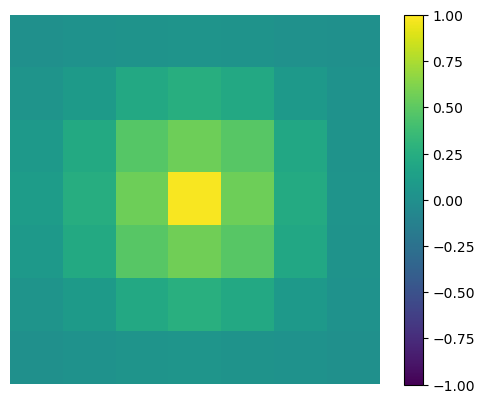

In [ ]:
heatmap2d(kernel2.view(7,7).detach().numpy(),fname='results/kernel_comb.jpg')

In [ ]:
bs = 5
train_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k=2
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


In [ ]:
with torch.no_grad():
    n = n_test
    h = 2./n
    n_mg_jac = 0
    mg_jac = MultiGrid(n=n, pacnet=my_net, device=device, nb_layers=nb_layers, iterator='jac') # create a multigrid model
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_jac,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_jac = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 6.110549691121599
1 1.3295650196568485
2 0.3174571773643661
3 0.07668325036273482
4 0.018650648505443148
5 0.004559167891875934
6 0.0011190032257235554
7 0.000275582882065503
8 6.807098679092244e-05
9 1.685891597214097e-05
10 4.185604010878452e-06
11 1.0415319534241137e-06
12 2.5972428354303925e-07
Solution converges after 12 Jacobi multigrid iterations in 0.10628223419189453 seconds.


In [ ]:
with torch.no_grad():
    h = 2./n
    n_mg_jac = 0
    mg_jac = MultiGrid(n=n, pacnet=my_net, device=device, nb_layers=nb_layers, iterator='psi') # create a multigrid model
    u_mg_psi = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_psi,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_psi = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgpsi = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_psi = mg_jac.Step(u_mg_psi)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgpsi.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Psi-Jacobi multigrid iterations in", end-start, 'seconds.')


0 6.110549691121599
1 0.40349303552428445
2 0.03253253526036652
3 0.0026649648955013277
4 0.00022204865784785198
5 1.895246564700488e-05
6 1.666710196088509e-06
7 1.5148893180103602e-07
Solution converges after 7 Psi-Jacobi multigrid iterations in 0.07870268821716309 seconds.


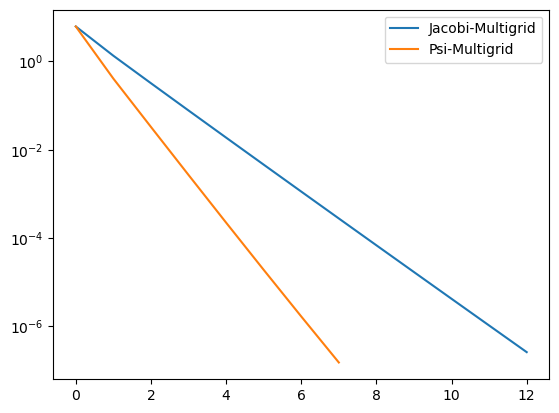

In [ ]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.plot(res_arr_mgpsi, label='Psi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

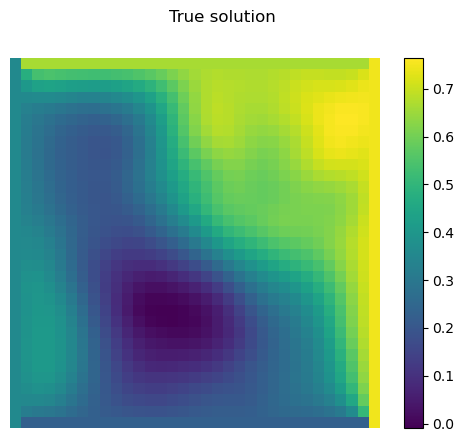

In [ ]:
plot.plot_thermalfield((solution_test).reshape(n+1,n+1), 'True solution')

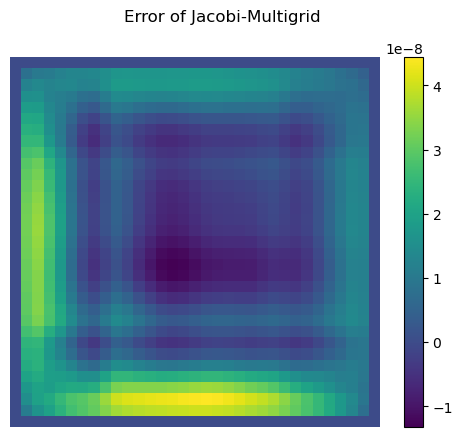

In [ ]:
plot.plot_thermalfield((u_mg_jac-solution_test).reshape(n+1,n+1), 'Error of Jacobi-Multigrid')

In [ ]:
u_mg_jac-solution_test

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 7.9839e-09, 1.0146e-08,  ..., 6.7189e-09,
           4.5821e-09, 0.0000e+00],
          [0.0000e+00, 1.2337e-08, 1.3741e-08,  ..., 7.9841e-09,
           6.2370e-09, 0.0000e+00],
          ...,
          [0.0000e+00, 1.5265e-08, 1.9797e-08,  ..., 1.3900e-08,
           9.2911e-09, 0.0000e+00],
          [0.0000e+00, 1.1066e-08, 1.6371e-08,  ..., 1.3201e-08,
           7.9108e-09, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]]], device='cuda:0', dtype=torch.float64)

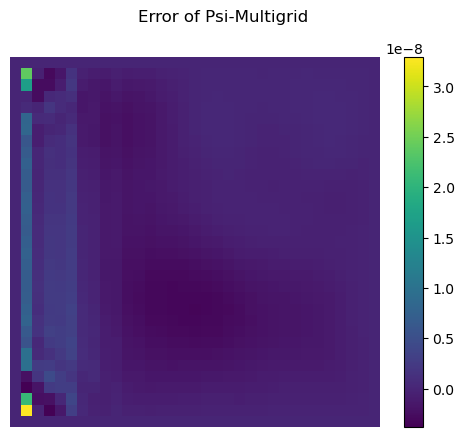

In [ ]:
plot.plot_thermalfield((u_mg_psi.detach()-solution_test).reshape(n+1,n+1), 'Error of Psi-Multigrid')

In [ ]:
u_mg_psi.detach()-solution_test

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  2.3956e-08, -4.3712e-10,  ...,  1.0531e-10,
            8.7275e-11,  0.0000e+00],
          [ 0.0000e+00,  1.6815e-08, -2.6341e-09,  ...,  1.8766e-10,
            1.2829e-10,  0.0000e+00],
          ...,
          [ 0.0000e+00,  2.0902e-08, -2.3621e-09,  ..., -3.1898e-10,
           -1.8509e-10,  0.0000e+00],
          [ 0.0000e+00,  3.2883e-08, -1.2684e-10,  ..., -1.5846e-10,
           -9.8735e-11,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]], device='cuda:0', dtype=torch.float64)